<a href="https://colab.research.google.com/github/DifferentLee/Lee_GitLearn/blob/main/_downloads/torchvision_finetuning_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 解压数据集

# Lab09
课程名称：机器学习
任课教师：米阳
班	级：E225
学	号：2022308310519
姓	名：李怡燃
日	期：2023年12月13日

In [ ]:
!unzip "/content/data/PennFudanPed.zip" -d "/content/data/PennFudanPed/"
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# TorchVision 目标检测微调教程
因此，每幅图像都有一个相应的分割掩码，其中每种颜色对应一个不同的实例。让我们为这个数据集编写一个 torch.utils.data.Dataset 类。在下面的代码中，我们将图像、边界框和掩码封装到 torchvision.tv_tensors.TVTensor 类中，这样我们就可以应用 torchvision 内置的变换（新的 Transforms API）来完成给定的对象检测和分割任务。也就是说，图像张量将由 torchvision.tv_tensors.Image 封装，边界框将由 torchvision.tv_tensors.BoundingBoxes 封装，掩码将由 torchvision.tv_tensors.Mask 封装。由于 torchvision.tv_tensors.TVTensor 是 torch.Tensor 的子类，因此封装对象也是张量，并继承了普通的 torch.Tensor API。有关 torchvision tv_tensors 的更多信息，请参阅此文档。


In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

这就是数据集的全部内容。现在我们来定义一个模型，它可以对这个数据集进行
预测的模型。

## 定义模型

在本教程中，我们将使用 [Mask
R-CNN](https://arxiv.org/abs/1703.06870)_，它基于
[Faster R-CNN](https://arxiv.org/abs/1506.01497)_。Faster R-CNN 是一个
模型，可预测图像中潜在对象的边界框和类得分。
图像中潜在物体的边界框和类别得分。


Mask R-CNN 在 Faster R-CNN 的基础上增加了一个分支
还能预测每个实例的分割掩码。
实例的分割掩码。


有两种常见的
有两种常见情况
修改 TorchVision Model Zoo 中的一个可用模型。第一种
是当我们想从预先训练好的模型开始，只对最后一层进行微调。
最后一层。另一种情况是，我们想用不同的模型替换模型的骨架
模型的骨干时（例如，为了加快预测速度）。

让我们在下面的章节中看看我们该如何做。

#### 1 - 根据预训练模型进行微调

假设您想从 COCO 上预先训练好的模型开始
上预先训练好的模型为起点，并针对您的特定类别对其进行微调。下面是一种可能的
方法：

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 2 - 修改模型以添加不同的主干网



In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

### 面向PennFudan数据集的目标检测与实例分割模型

在我们的案例中，鉴于我们的数据集非常小，我们希望从预先训练好的模型中进行微调。
我们的数据集非常小，因此我们将采用第 1 种方法。

在这里，我们还想计算实例分割掩码，因此我们将使用掩码 R-CNN
使用掩码 R-CNN：



In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

就是这样，这将使 ``model`` 准备好在您的自定义数据集上进行训练和评估。
在自定义数据集上进行训练和评估。

## 把所有东西放在一块

在 ``references/detection/`` 中，我们有许多辅助函数来简化训练和评估检测模型。
以简化检测模型的训练和评估。在此，我们将使用
`references/detection/engine.py`` 和 `references/detection/utils.py``。
只需将 ``references/detection`` 下的所有内容下载到你的文件夹，然后在这里使用它们。
在 Linux 上，如果你有 ``wget``，可以使用以下命令下载它们：

In [15]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss_classifier': tensor(0.0785, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0177, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0075, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0011, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


现在让我们编写执行训练和
验证的主函数：


In [16]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 152MB/s]


Epoch: [0]  [ 0/60]  eta: 0:04:41  lr: 0.000090  loss: 5.5669 (5.5669)  loss_classifier: 0.8241 (0.8241)  loss_box_reg: 0.4975 (0.4975)  loss_mask: 4.2180 (4.2180)  loss_objectness: 0.0162 (0.0162)  loss_rpn_box_reg: 0.0110 (0.0110)  time: 4.6971  data: 0.3371  max mem: 2600
Epoch: [0]  [10/60]  eta: 0:00:46  lr: 0.000936  loss: 1.7502 (2.7189)  loss_classifier: 0.5712 (0.5108)  loss_box_reg: 0.3018 (0.3013)  loss_mask: 0.9622 (1.8752)  loss_objectness: 0.0206 (0.0267)  loss_rpn_box_reg: 0.0030 (0.0050)  time: 0.9278  data: 0.0385  max mem: 3380
Epoch: [0]  [20/60]  eta: 0:00:29  lr: 0.001783  loss: 1.1733 (1.8063)  loss_classifier: 0.2527 (0.3658)  loss_box_reg: 0.2996 (0.2858)  loss_mask: 0.5033 (1.1287)  loss_objectness: 0.0161 (0.0188)  loss_rpn_box_reg: 0.0053 (0.0072)  time: 0.5483  data: 0.0095  max mem: 3380
Epoch: [0]  [30/60]  eta: 0:00:20  lr: 0.002629  loss: 0.6842 (1.4225)  loss_classifier: 0.1264 (0.2809)  loss_box_reg: 0.2996 (0.2830)  loss_mask: 0.2520 (0.8345)  loss_ob

因此，经过一个时期的训练，我们获得了 COCO 风格的 mAP > 50，并且
掩码 mAP 为 65。

但是预测是什么样的呢？让我们在数据集验证





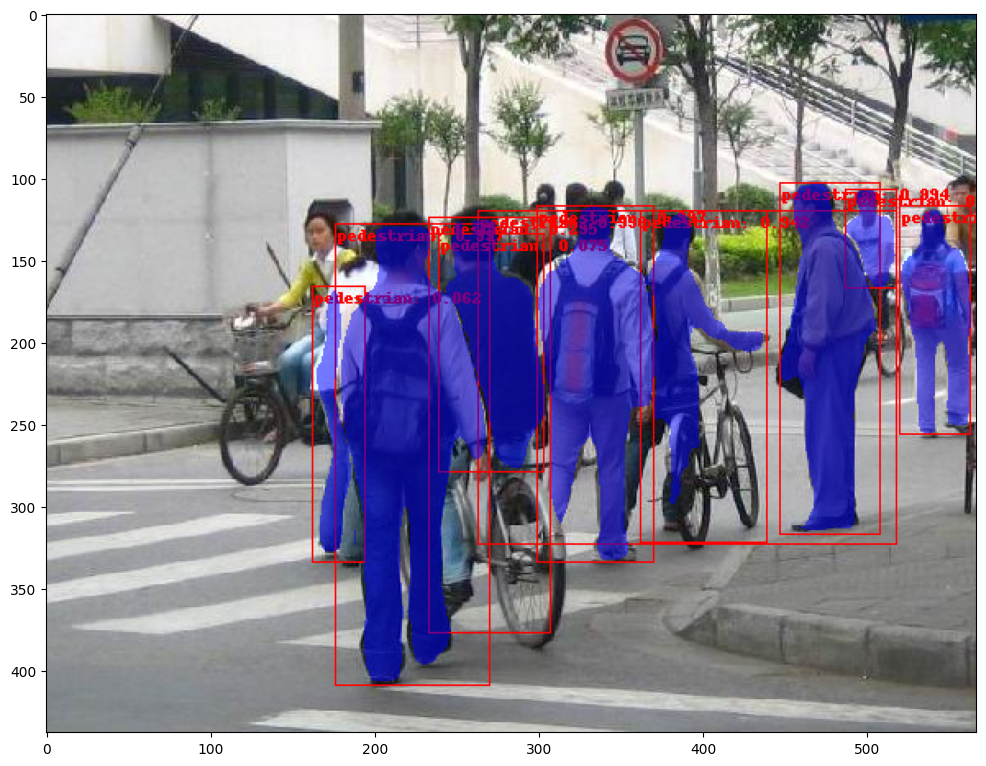

In [20]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("./data/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

结果看起来很不错

